In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


dataset/test.csv
dataset/train.csv


In [95]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

In [96]:
print("shape of train data {}\n".format(train.shape))
print("shape of test data {}\n".format(test.shape))

shape of train data (8068, 11)

shape of test data (2627, 10)



In [97]:
# Reset the index before handling missing values
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print("shape of train data {}\n".format(train.shape))
print("shape of test data {}\n".format(test.shape))

shape of train data (8068, 11)

shape of test data (2627, 10)



In [98]:
df_train = [x for x in train if x not in test]
print("Column in train data but not in test data {}\n".format(df_train))

df_test = [x for x in test if x not in train]
print("Column in test data but not in train data {}\n".format(df_test))

Column in train data but not in test data ['Segmentation']

Column in test data but not in train data []



In [99]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [100]:
test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [102]:
# Select relevant columns for clustering
columns_for_clustering = ['Age', 'Work_Experience', 'Family_Size']

In [103]:
# Check for missing values in the training dataset before handling them
print("Number of missing values in training dataset before handling: {}\n".format(train[columns_for_clustering].isnull().sum()))

# Handle missing values in the training dataset
X_train = train[columns_for_clustering].replace([np.inf, -np.inf], np.nan).dropna().values

Number of missing values in training dataset before handling: Age                  0
Work_Experience    829
Family_Size        335
dtype: int64



In [104]:
# Check the length of values and index before clustering
print("Length of values in training dataset: {}".format(len(X_train)))
print("Length of index in training dataset: {}".format(len(train)))



Length of values in training dataset: 6969
Length of index in training dataset: 8068


In [105]:
customer=pd.concat([train[['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size']],test[['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size']]],ignore_index=True)
customer.sample(5)


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
6418,467734,Male,Yes,79,Yes,Lawyer,2.0,High,2.0
9178,462705,Female,Yes,66,No,Lawyer,0.0,Average,2.0
3859,460961,Male,No,20,No,Healthcare,1.0,Low,2.0
9619,464217,Female,No,30,No,Healthcare,14.0,Low,3.0
9150,462600,Male,Yes,25,No,Engineer,4.0,Average,3.0


In [106]:
customer.describe()

,ID,Age,Work_Experience,Family_Size
count,10695.000000,10695.000000,9597.000000,10247.000000
mean,463468.088640,43.511828,2.619777,2.844052
std,2600.966411,16.774158,3.390790,1.536427
min,458982.000000,18.000000,0.000000,1.000000
25%,461220.500000,30.000000,0.000000,2.000000
50%,463451.000000,41.000000,1.000000,3.000000
75%,465733.500000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [107]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 752.1+ KB


In [108]:
customer.isna().sum()

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
dtype: int64

<Axes: >

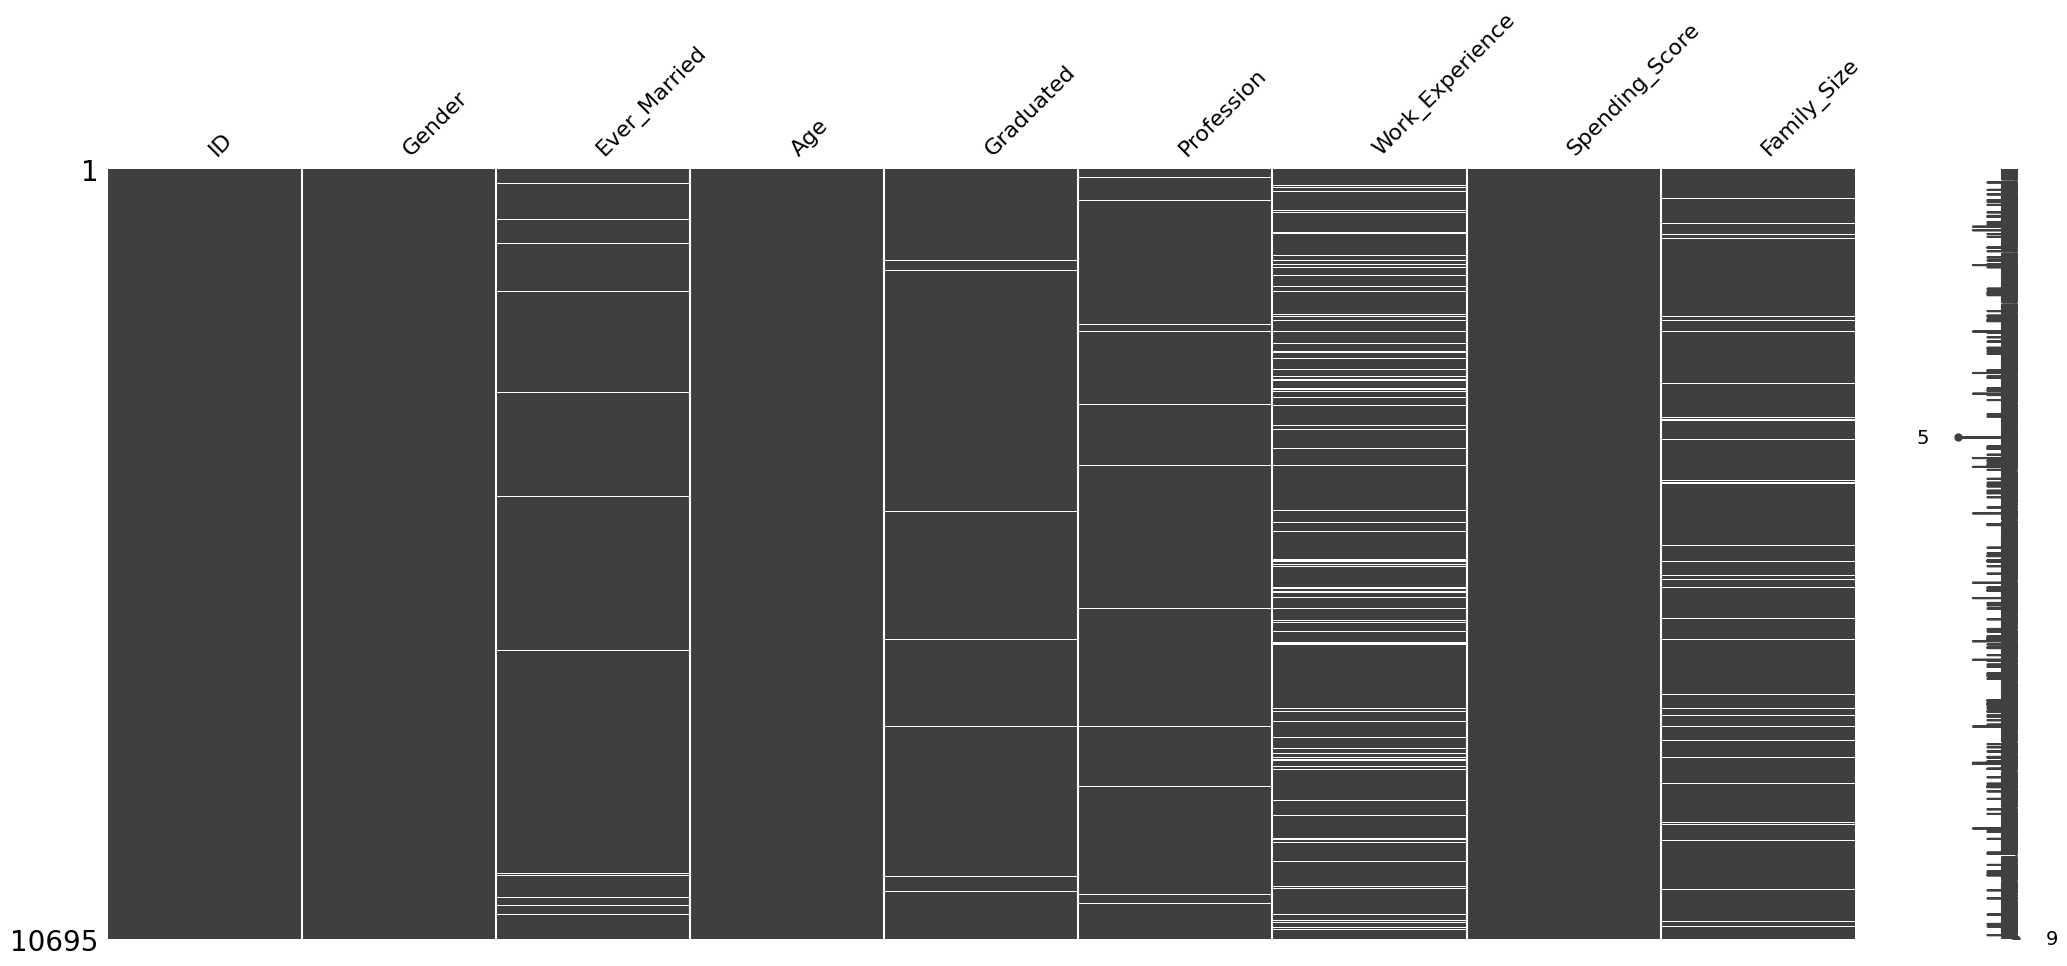

In [109]:
msno.matrix(customer)

In [110]:
customer.fillna(method='ffill',inplace=True)

In [111]:
customer.sample(4)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
9351,463269,Male,Yes,41,Yes,Entertainment,3.0,Average,2.0
1918,466512,Female,No,22,No,Healthcare,1.0,Low,2.0
4093,463398,Male,No,29,No,Marketing,9.0,Low,4.0
2931,466682,Male,Yes,62,No,Entertainment,2.0,Average,4.0


In [112]:
customer.drop('ID',axis=1,inplace=True)

In [113]:
customer.sample(4)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
9412,Male,Yes,47,Yes,Executive,0.0,Low,2.0
5219,Female,No,27,No,Engineer,1.0,Low,1.0
4879,Female,Yes,60,Yes,Artist,0.0,Average,4.0
2515,Female,Yes,84,No,Lawyer,0.0,High,2.0


Gender
Male      5841
Female    4854
Name: count, dtype: int64

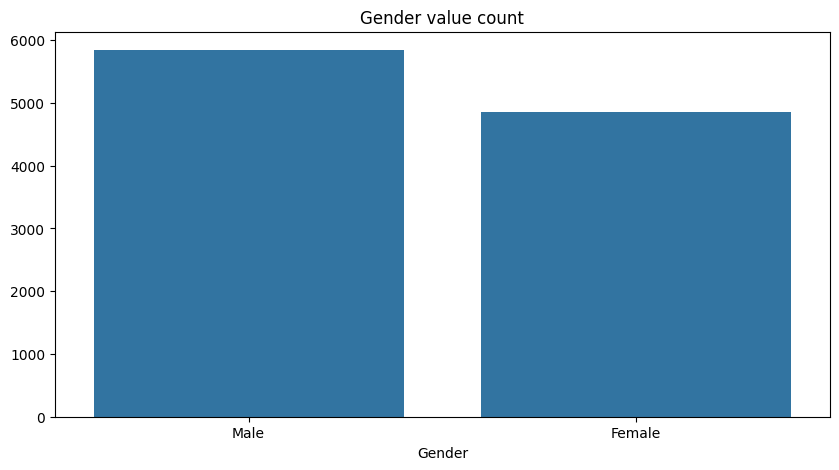

Ever_Married
Yes    6268
No     4427
Name: count, dtype: int64

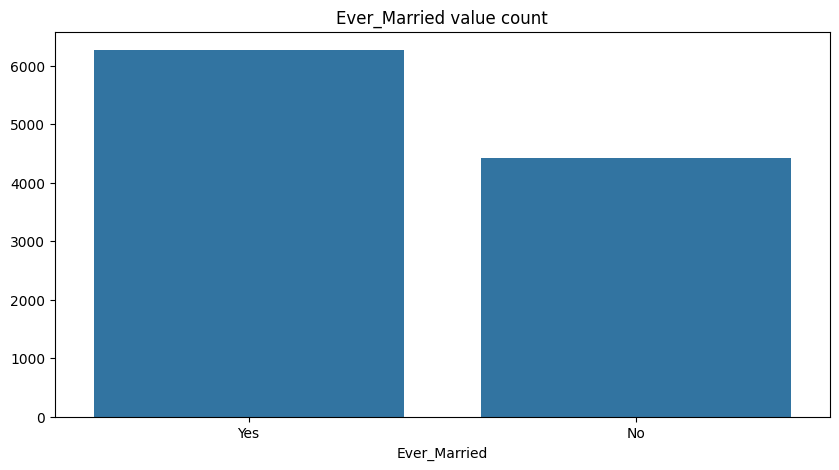

Age
35    321
42    320
37    304
43    301
40    300
     ... 
75     37
78     36
76     36
80     33
85     32
Name: count, Length: 67, dtype: int64

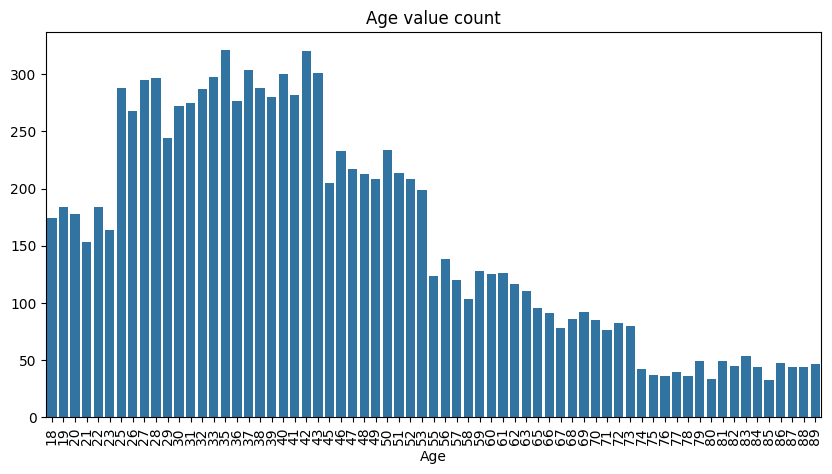

Graduated
Yes    6641
No     4054
Name: count, dtype: int64

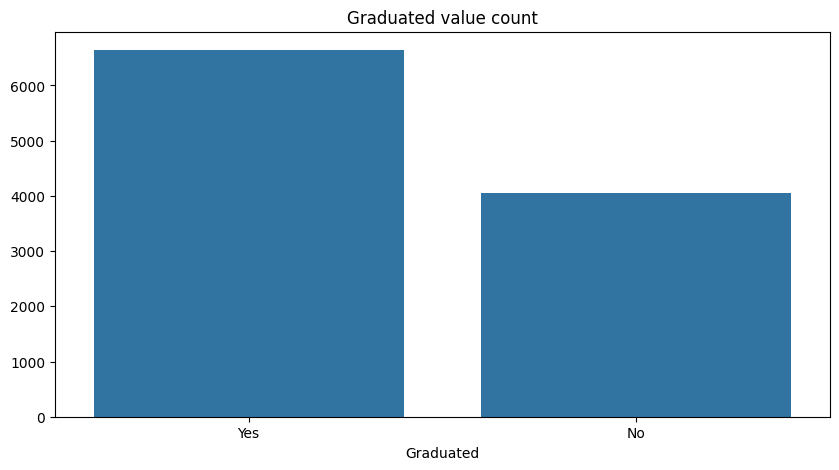

Profession
Artist           3363
Healthcare       1779
Entertainment    1268
Doctor            953
Engineer          942
Lawyer            859
Executive         783
Marketing         412
Homemaker         336
Name: count, dtype: int64

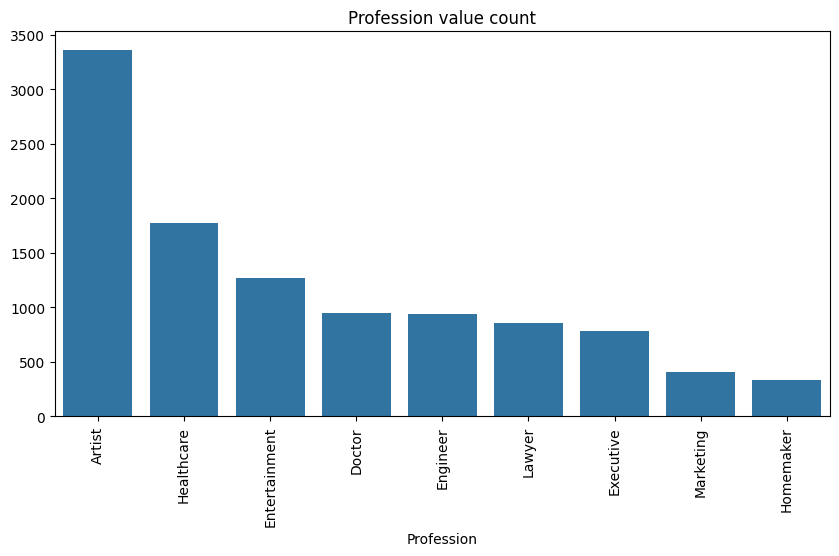

Work_Experience
1.0     3478
0.0     3455
8.0      686
9.0      677
2.0      417
4.0      380
3.0      379
6.0      301
5.0      294
7.0      286
14.0      77
11.0      74
10.0      69
12.0      62
13.0      60
Name: count, dtype: int64

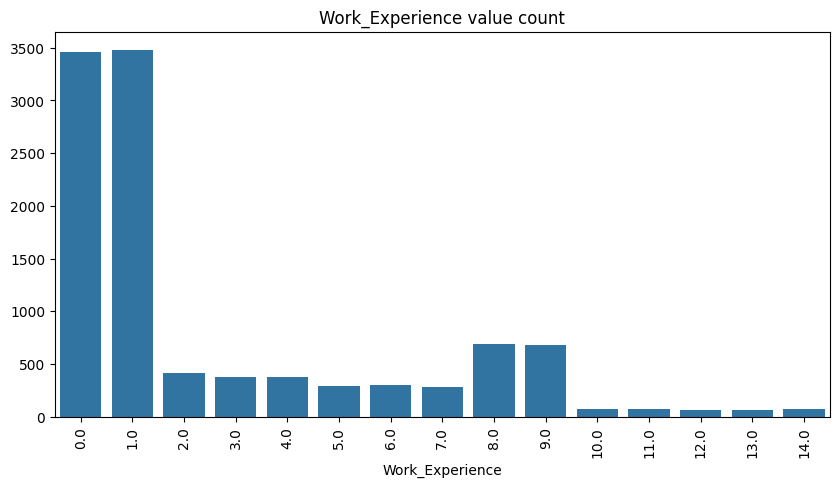

Spending_Score
Low        6494
Average    2599
High       1602
Name: count, dtype: int64

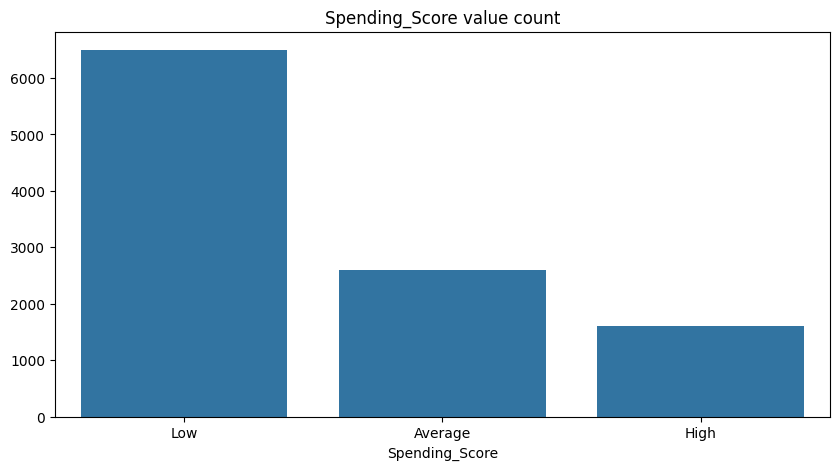

Family_Size
2.0    3288
1.0    2065
3.0    2032
4.0    1901
5.0     846
6.0     301
7.0     131
9.0      66
8.0      65
Name: count, dtype: int64

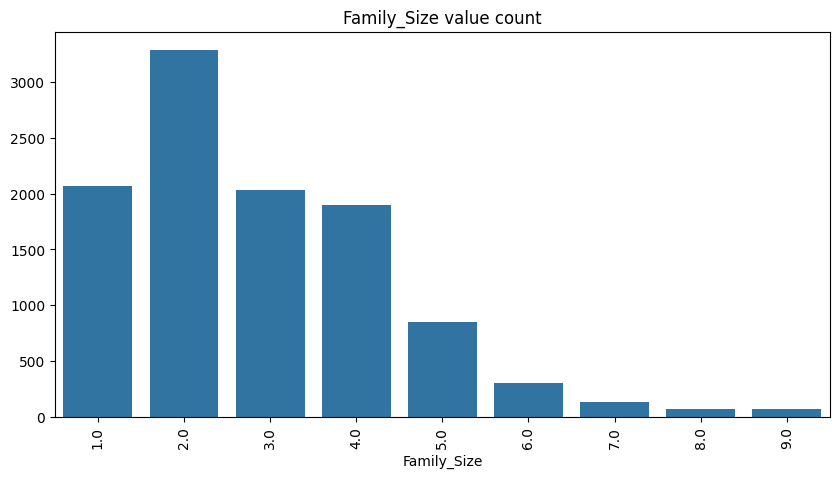

In [114]:
for i in customer.columns:
    display(customer[i].value_counts())
    plt.figure(figsize=(10,5))
    sns.barplot(x=customer[i].value_counts().index, y=customer[i].value_counts().values)
    if len(customer[i].value_counts().index) >= 9:
        plt.xticks(rotation=90)
    plt.title(f'{i} value count')
    plt.show()


In [115]:
encode=OrdinalEncoder(dtype=object)
customer_encode=pd.DataFrame(encode.fit_transform(customer),columns=customer.columns)
customer_encode.head(3)


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,1,0,4,0,5,1,2,3
1,0,1,18,1,2,1,0,2
2,0,1,44,1,2,1,2,0


In [116]:
customer.head(3)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0


In [117]:
stand=StandardScaler()
stand=stand.fit_transform(customer_encode)
stand

array([[ 0.91160413, -1.189898  , -1.25146663, ..., -0.47601426,
         0.75057469,  0.75099591],
       [-1.09696739,  0.84040817, -0.33671597, ..., -0.47601426,
        -1.61042423,  0.101796  ],
       [-1.09696739,  0.84040817,  1.36210668, ..., -0.47601426,
         0.75057469, -1.19660381],
       ...,
       [-1.09696739, -1.189898  ,  0.57803469, ..., -0.47601426,
         0.75057469, -0.5474039 ],
       [ 0.91160413,  0.84040817,  0.18599869, ..., -0.47601426,
        -0.42992477,  1.40019581],
       [-1.09696739, -1.189898  , -0.01001931, ...,  1.88652301,
         0.75057469,  0.101796  ]])

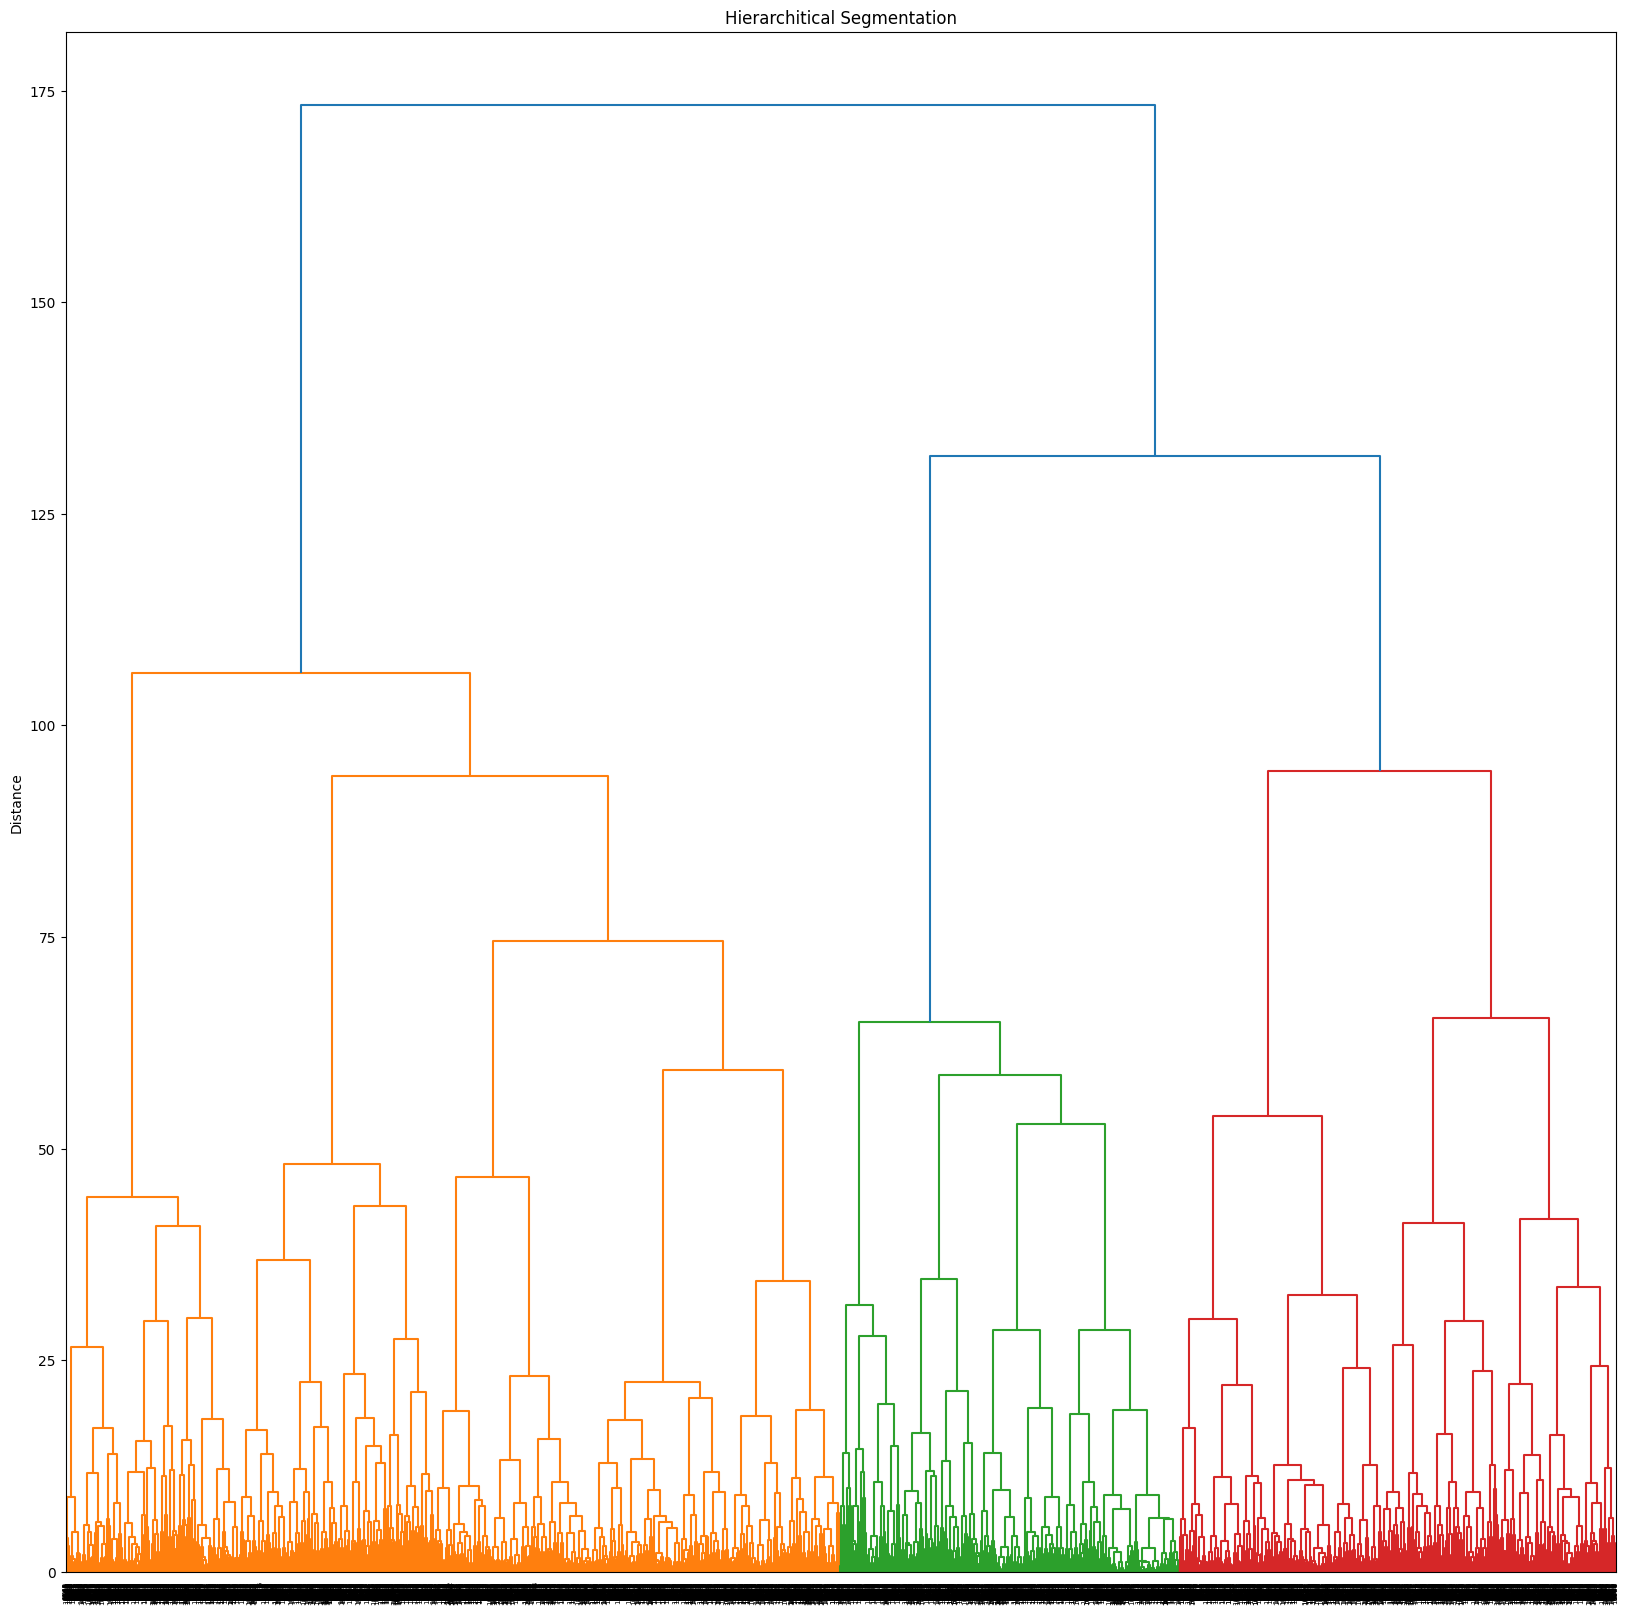

In [118]:
link=linkage(stand,'ward')
plt.figure(figsize=(20,20))
dendrogram(link,p=5)
plt.ylabel('Distance')
plt.title('Hierarchitical Segmentation')
plt.show()

In [119]:
# Select relevant columns for clustering
columns_for_clustering = ['Age', 'Work_Experience', 'Family_Size']
#X = test[columns_for_clustering].replace([np.inf, -np.inf], np.nan).dropna().values


In [120]:
# One-hot encode categorical columns in training data
categorical_columns = ['Spending_Score', 'Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']
train_encoded = pd.get_dummies(train, columns=categorical_columns)


In [121]:
# Impute missing values in training data
imputer = SimpleImputer(strategy='mean')  # You can choose a different imputation strategy if needed
X_train = imputer.fit_transform(train_encoded[columns_for_clustering].values)

# Generate distance matrix with 'linkage' function for training data
distances_train = linkage(X_train, method="ward", metric="euclidean")


In [122]:
# Perform hierarchical clustering for training data
num_clusters_train = 4  # Adjust based on your criteria
train['Segmentation'] = fcluster(distances_train, num_clusters_train, criterion='maxclust')


In [123]:
# One-hot encode categorical columns in test data
test_encoded = pd.get_dummies(test, columns=categorical_columns)

In [124]:
# Impute missing values in test data
X_test = imputer.transform(test_encoded[columns_for_clustering].values)


In [125]:
# Generate distance matrix with 'linkage' function for test data
distances_test = linkage(X_test, method="ward", metric="euclidean")


In [126]:
# Perform hierarchical clustering for test data
num_clusters_test = 4  # Adjust based on your criteria
test['Segmentation'] = fcluster(distances_test, num_clusters_test, criterion='maxclust')


In [127]:
# Display the count of each cluster in training data
print(train['Segmentation'].value_counts().sort_values(ascending=True))


Segmentation
1     502
2    1406
3    2693
4    3467
Name: count, dtype: int64


In [128]:
# Display the count of each cluster in test data
print(test['Segmentation'].value_counts().sort_values(ascending=True))


Segmentation
1     157
2     456
3     857
4    1157
Name: count, dtype: int64


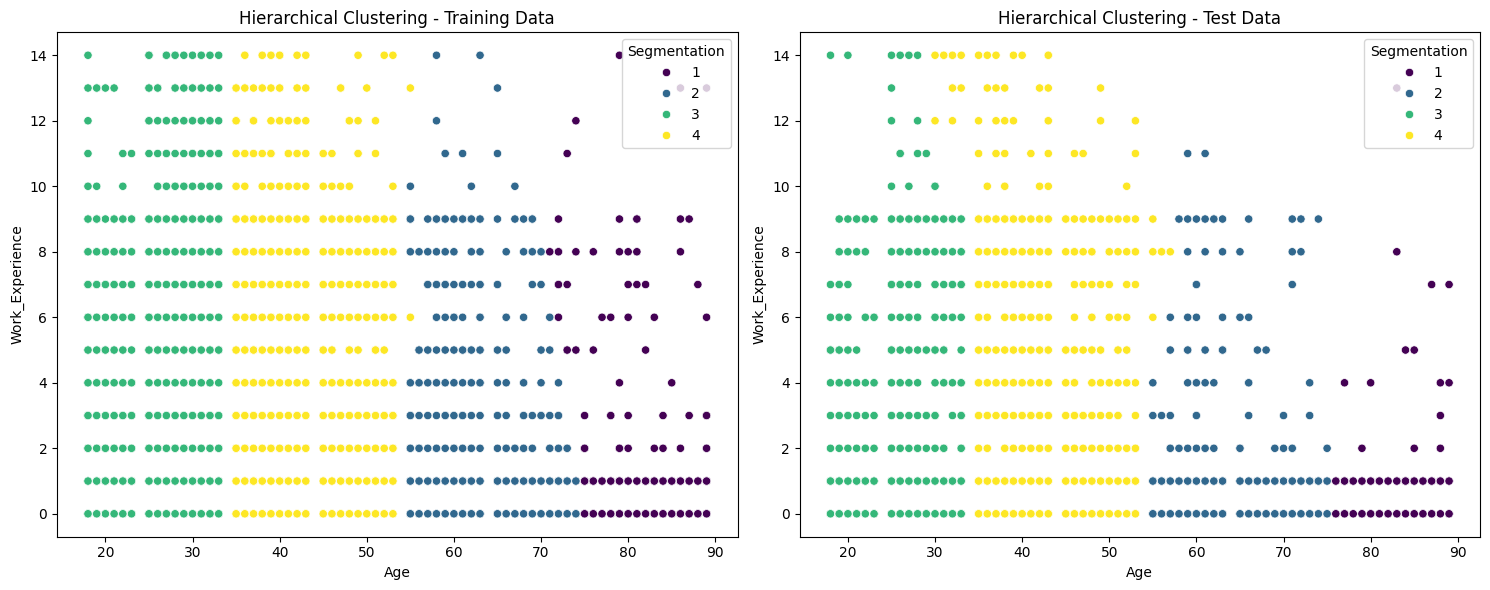

In [129]:
# Set up a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Visualize clusters in the training data
sns.scatterplot(x='Age', y='Work_Experience', hue='Segmentation', data=train, palette='viridis', legend='full', ax=axes[0])
axes[0].set_title('Hierarchical Clustering - Training Data')

# Visualize clusters in the test data
sns.scatterplot(x='Age', y='Work_Experience', hue='Segmentation', data=test, palette='viridis', legend='full', ax=axes[1])
axes[1].set_title('Hierarchical Clustering - Test Data')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

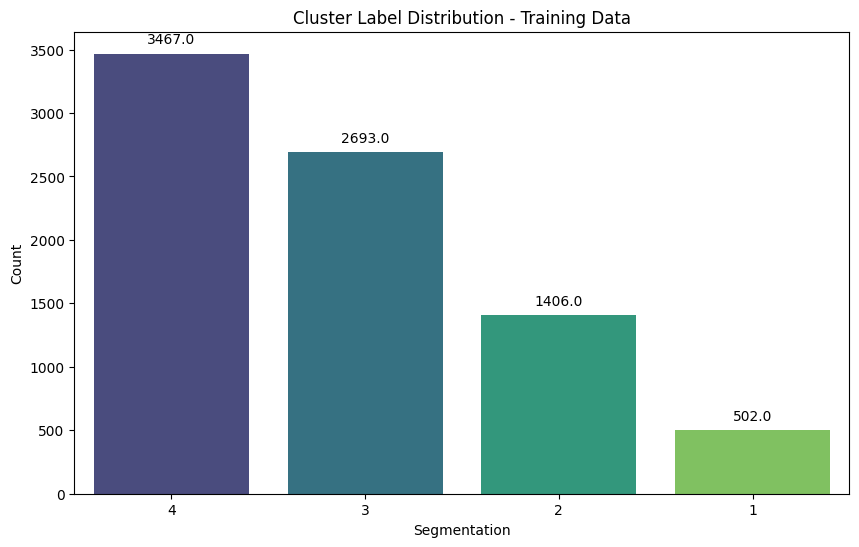

In [132]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the count of each cluster label in the training data
sns.countplot(x=train['Segmentation'], palette='viridis', order=train['Segmentation'].value_counts().index)

# Annotate each bar with its count
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.xlabel('Segmentation')
plt.ylabel('Count')
plt.title('Cluster Label Distribution - Training Data')

# Show the plot
plt.show()

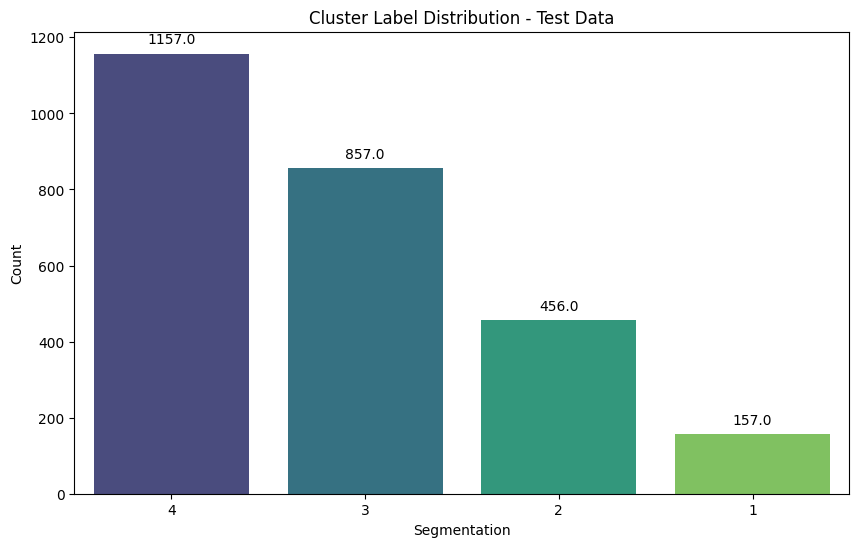

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the count of each cluster label in the test data
sns.countplot(x=test['Segmentation'], palette='viridis', order=test['Segmentation'].value_counts().index)

# Annotate each bar with its count
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.xlabel('Segmentation')
plt.ylabel('Count')
plt.title('Cluster Label Distribution - Test Data')

# Show the plot
plt.show()

Gender
Male      1424
Female    1203
Name: count, dtype: int64

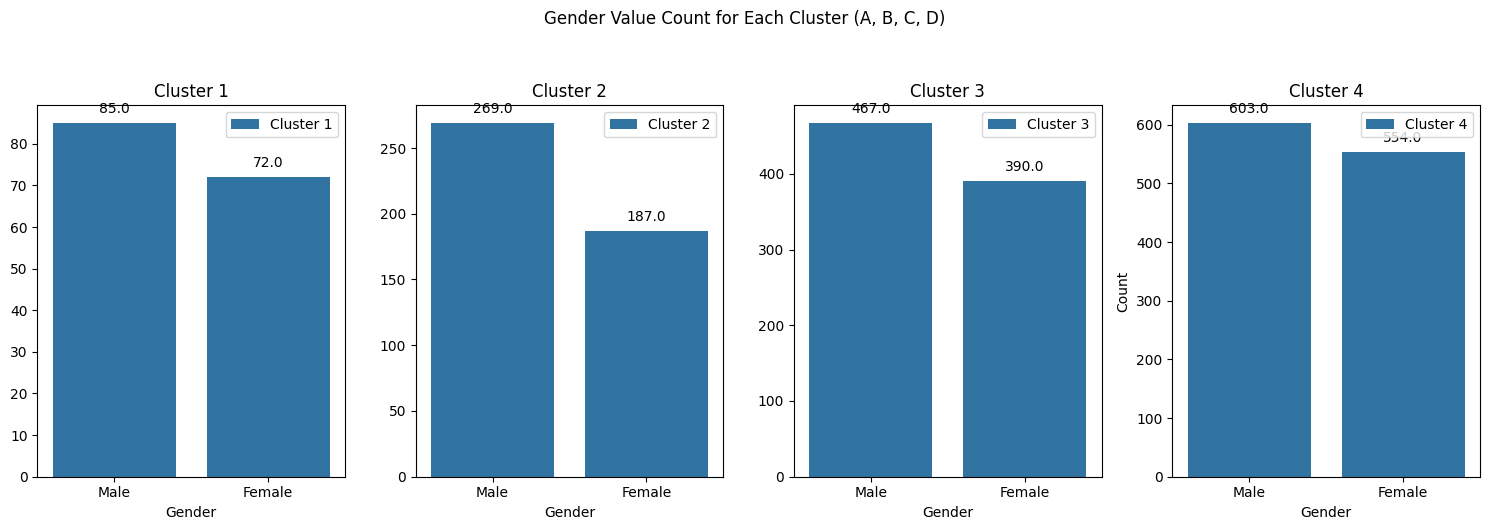

Ever_Married
Yes    1520
No     1057
Name: count, dtype: int64

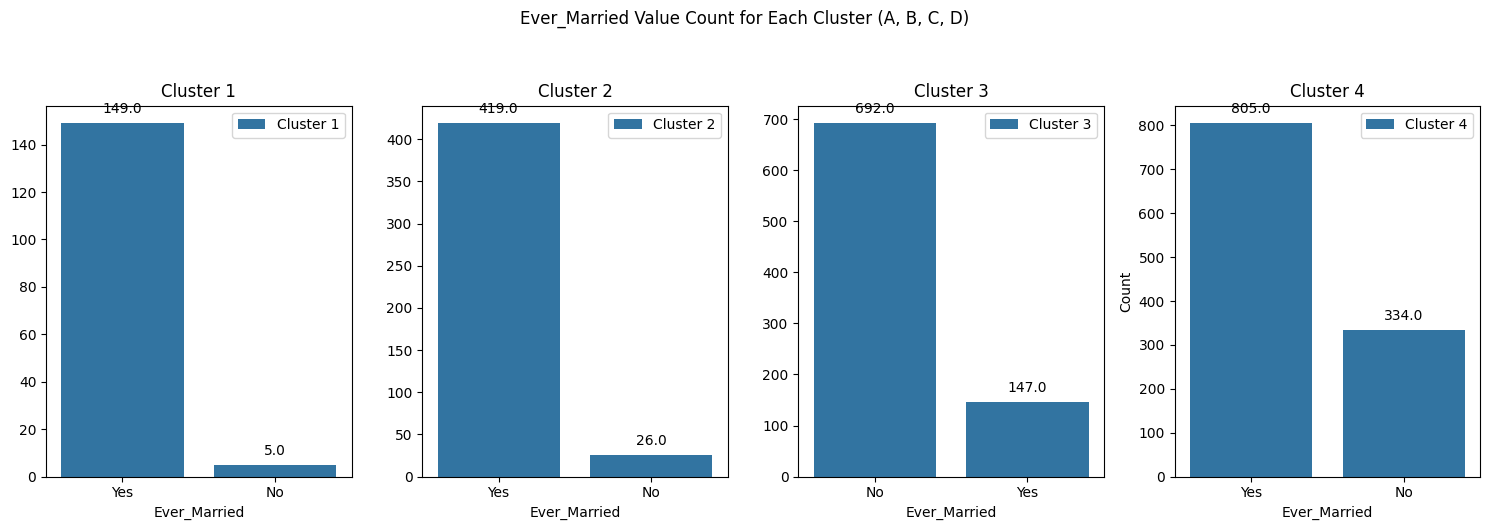

Age
42    88
28    77
30    76
41    76
43    75
      ..
82     9
88     9
81     7
78     7
75     5
Name: count, Length: 67, dtype: int64

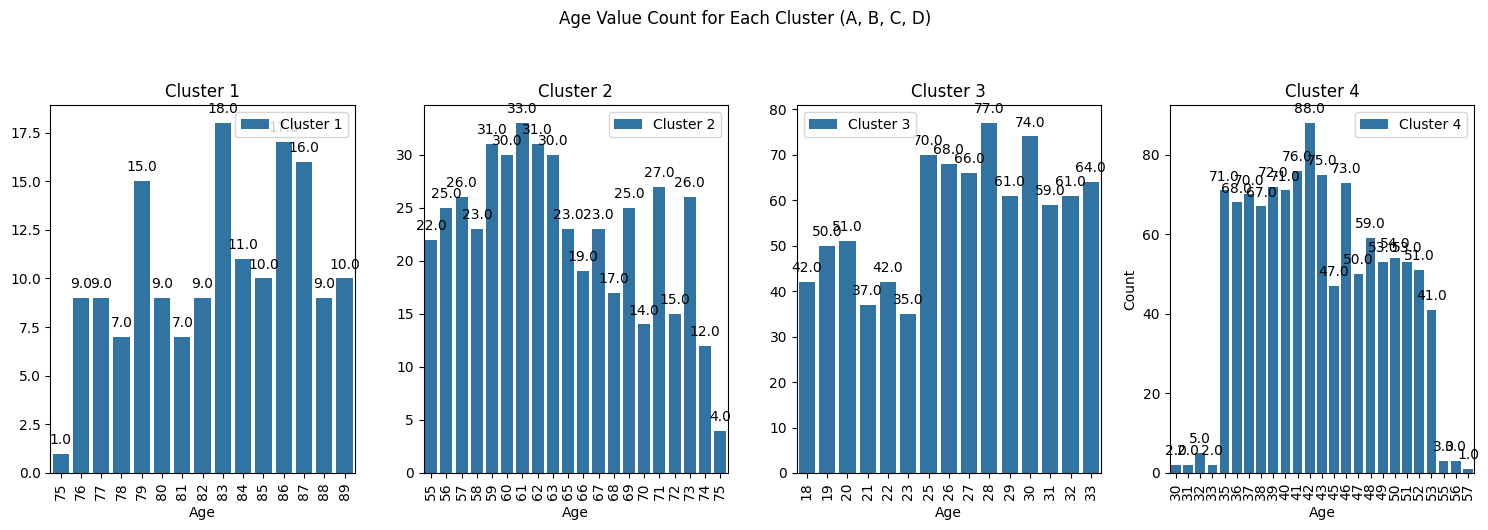

Graduated
Yes    1602
No     1001
Name: count, dtype: int64

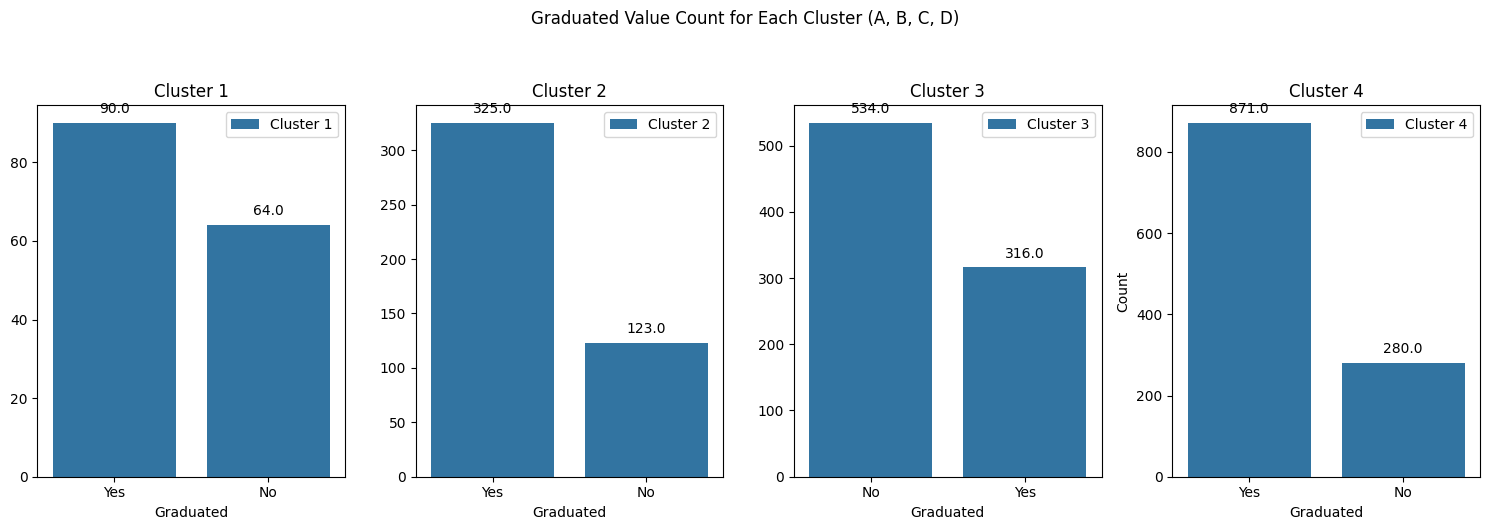

Profession
Artist           802
Healthcare       418
Entertainment    301
Doctor           242
Engineer         236
Lawyer           221
Executive        176
Marketing        111
Homemaker         82
Name: count, dtype: int64

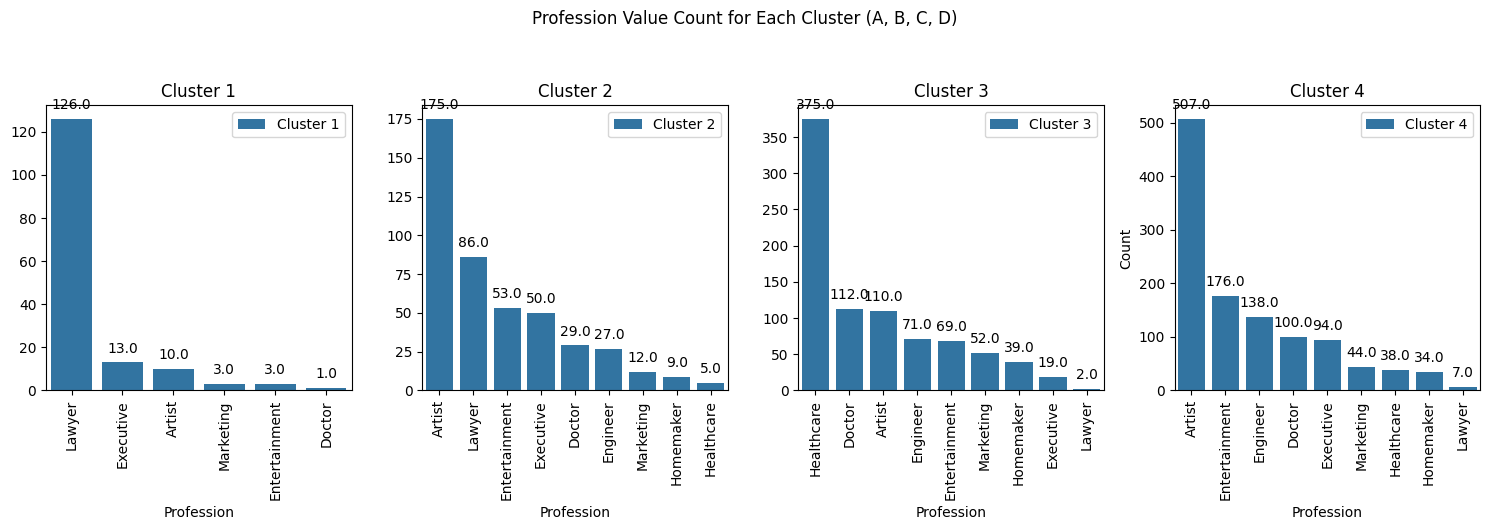

Work_Experience
1.0     773
0.0     769
8.0     149
9.0     139
4.0      93
2.0      87
3.0      82
5.0      76
6.0      61
7.0      60
14.0     21
11.0     14
12.0     12
13.0     11
10.0     11
Name: count, dtype: int64

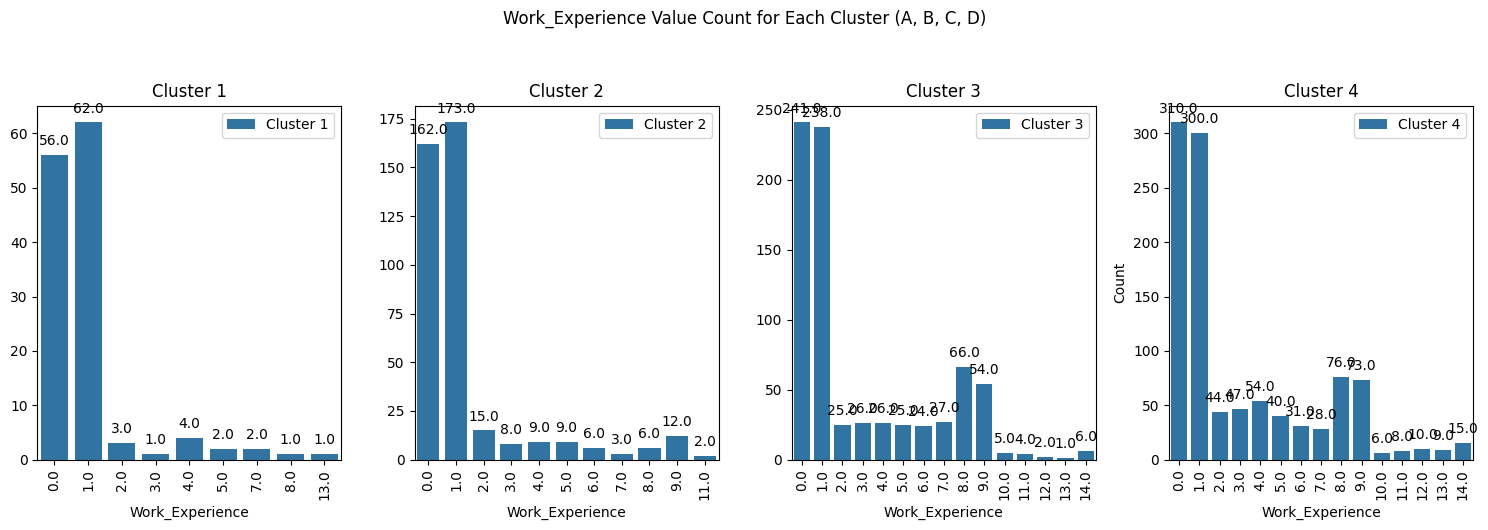

Spending_Score
Low        1616
Average     625
High        386
Name: count, dtype: int64

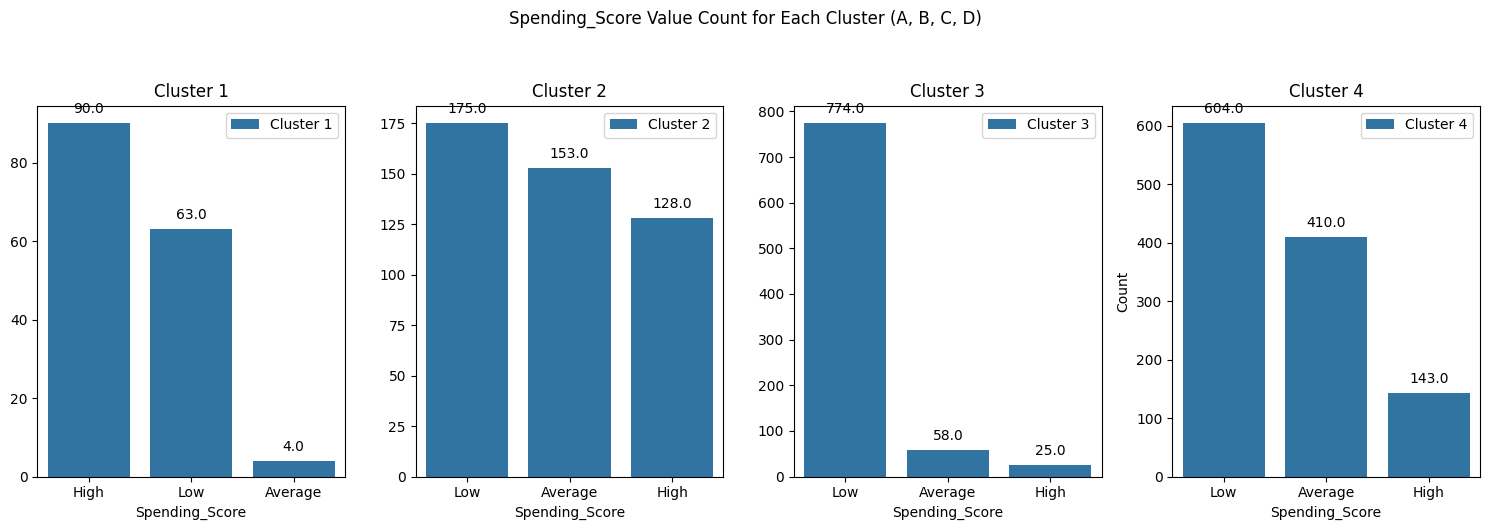

Family_Size
2.0    768
1.0    512
3.0    455
4.0    444
5.0    200
6.0     78
7.0     26
9.0     16
8.0     15
Name: count, dtype: int64

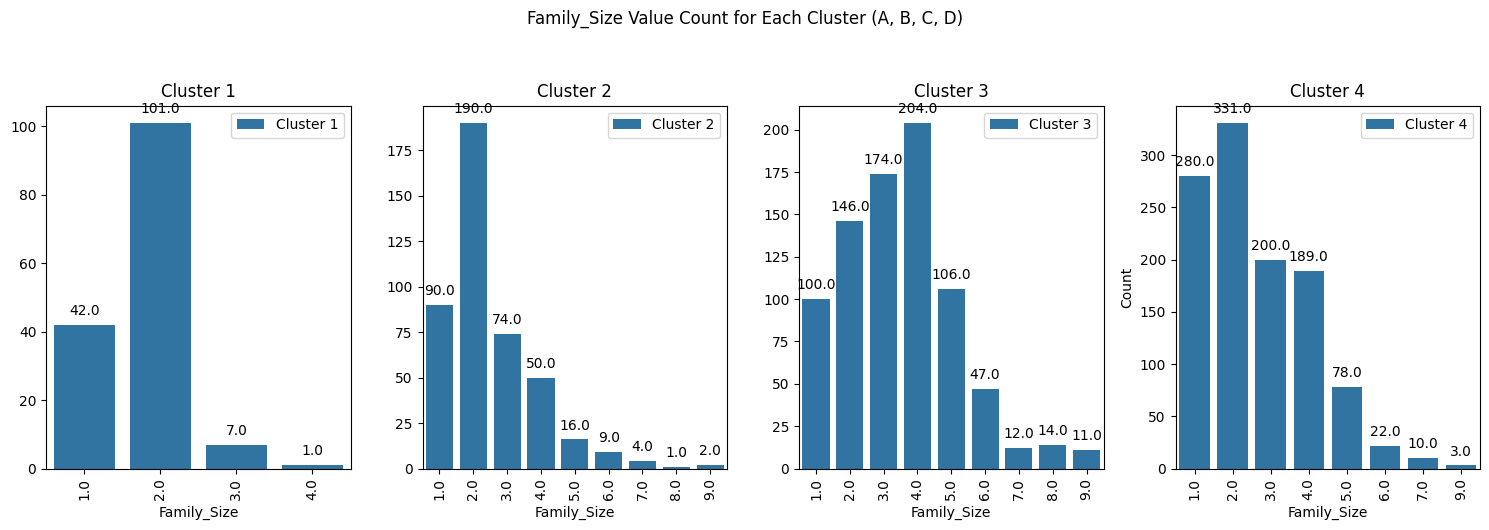

Var_1
Cat_6    1672
Cat_4     386
Cat_3     267
Cat_2     141
Cat_7      66
Cat_1      34
Cat_5      29
Name: count, dtype: int64

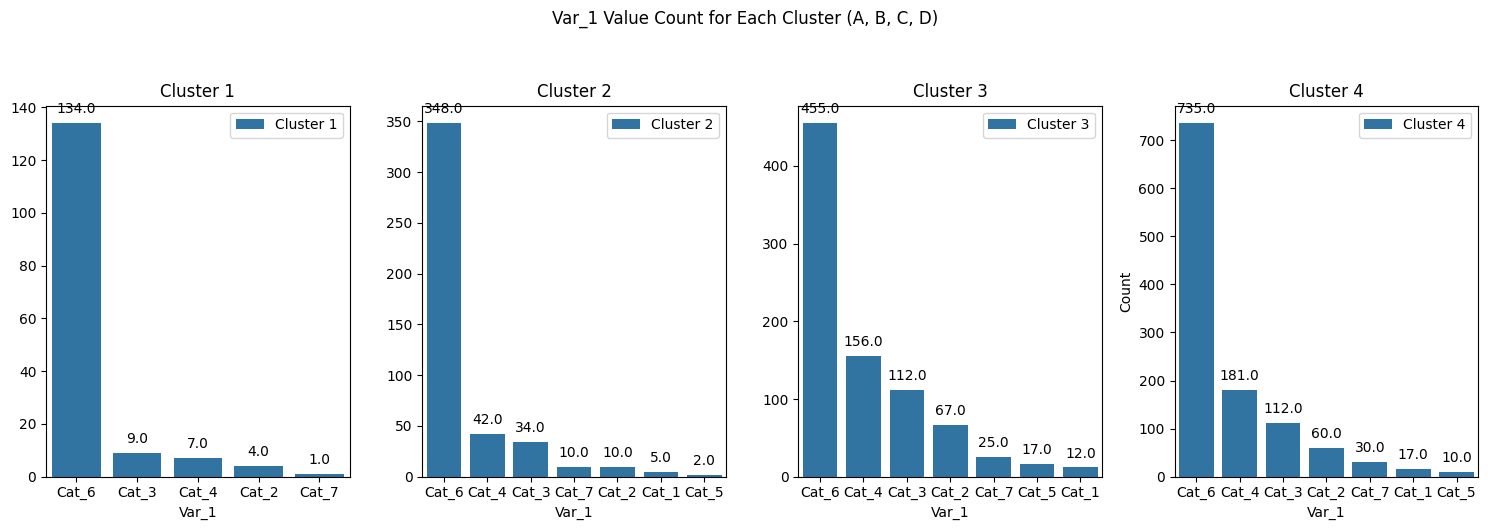

Segmentation
4    1157
3     857
2     456
1     157
Name: count, dtype: int64

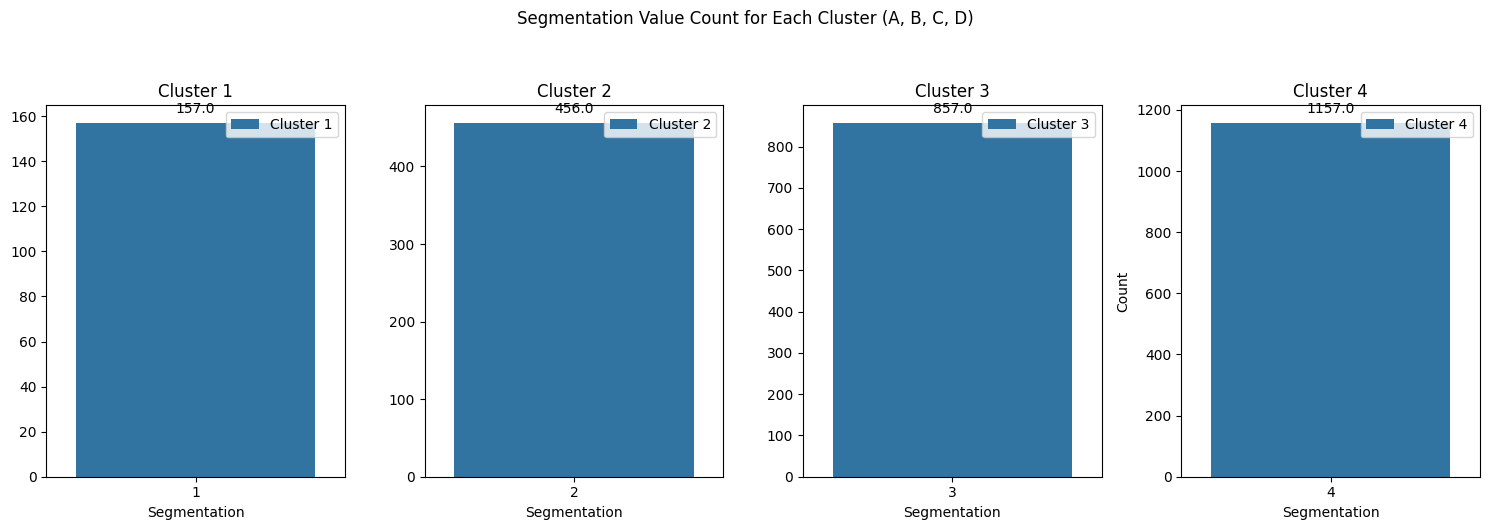

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'test' is your test dataset with the 'Segmentation' column
# Replace 'Segmentation' with the actual column name if different
for i in test.columns:
    if i != 'ID':  # Exclude 'ID' column
        # Display value counts for the entire test dataset
        display(test[i].value_counts())

        # Set up the plot
        plt.figure(figsize=(15, 5))

        # Iterate through each cluster and create a side-by-side bar plot
        for idx, cluster_label in enumerate(sorted(test['Segmentation'].unique())):
            plt.subplot(1, 4, idx + 1)
            sns.barplot(x=test[test['Segmentation'] == cluster_label][i].value_counts().index,
                        y=test[test['Segmentation'] == cluster_label][i].value_counts().values,
                        label=f'Cluster {cluster_label}')
            plt.title(f'Cluster {cluster_label}')

            if len(test[i].value_counts().index) >= 9:
                plt.xticks(rotation=90)

            # Annotate each bar with its count
            for p in plt.gca().patches:
                plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        # Set common labels and title
        plt.xlabel(i)
        plt.ylabel('Count')
        plt.suptitle(f'{i} Value Count for Each Cluster (A, B, C, D)', y=1.05)

        # Adjust layout for better readability
        plt.tight_layout()

        # Show the plot
        plt.show()
